In [1]:
import numpy as np 
import pandas as pd
from pandarallel import pandarallel
import matplotlib.pyplot as plt 
import seaborn as sns 
from collections import Counter
from wordcloud import WordCloud
import nltk
import spacy
import textacy.extract as textract
nltk.download("punkt")
nltk.download('stopwords')
import os , re 
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer , TfidfTransformer
from sklearn.decomposition import NMF , LatentDirichletAllocation , TruncatedSVD 
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import pyLDAvis

C:\Users\oscar\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\oscar\AppData\Local\Temp\ipykernel_2476\2640607317.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\oscar\anaconda3\lib\site-packages\torch\cuda\__init__.py:651: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: ht

In [2]:
df = pd.read_csv("../data/cleaned_data/cleaned_data.csv")
df = df.sample(n=int(len(df)) , random_state=42).reset_index(drop=True)


In [3]:
df = pd.read_csv("../data/cleaned_data/cleaned_data.csv")
df = df.sample(n=int(len(df)*0.15) , random_state=42).reset_index(drop=True)
df.head()

text_cleaned    targe  \
0  لقي قاصر يبلغ من العمر سنة مصرعه اليوم الخميس ...  diverse   
1  أعلنت الجامعة الملكية لكرة القدم في وقت سابق أ...   sports   
2  تحركات مكثفة يعرفها مجلس المستشارين من أجل تشك...  politic   
3  أخبارنا المغربية ارتأينا أن نقدم إلى القراء ال...  politic   
4  باشرت فرقة من الدرك الملكي التابعة للمركز التر...  diverse   

                                              tokens  
0  ['لقي', 'قاصر', 'يبلغ', 'من', 'العمر', 'سنة', ...  
1  ['أعلنت', 'الجامعة', 'الملكية', 'لكرة', 'القدم...  
2  ['تحركات', 'مكثفة', 'يعرفها', 'مجلس', 'المستشا...  
3  ['أخبارنا', 'المغربية', 'ارتأينا', 'أن', 'نقدم...  
4  ['باشرت', 'فرقة', 'من', 'الدرك', 'الملكي', 'ال...

In [4]:
df.shape

(16253, 3)

In [5]:
#tfidf
vectorizer =TfidfVectorizer(min_df=5 , max_df=0.7 , ngram_range=(1,2) ,stop_words=nltk.corpus.stopwords.words("arabic"))
vectors = vectorizer.fit_transform(df['text_cleaned'])

c:\Users\oscar\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'أب', 'أخ', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إم', 'ات', 'اتان', 'ارتد', 'ان', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  warnings.warn(


In [6]:
feature_names = vectorizer.get_feature_names_out()
print(len(feature_names))

103783


In [7]:
#how to solve this issues 
#filter data according verbs , noun , adjective 
#make also lemmization 

In [8]:
arabic_stopwords = nltk.corpus.stopwords.words("arabic")
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])

C:\Users\oscar\AppData\Roaming\Python\Python310\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.6.0) was trained with spaCy v3.6.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [9]:
def extract_useful_words(text, include_pos = ['NOUN', 'ADJ' , 'VERB','ADV'] , stopwords = arabic_stopwords):
    doc = nlp(text)
    
    tokens = textract.words(doc , 
                            filter_nums=False , #bevause we acually remove it
                            include_pos=include_pos , 
                            exclude_pos= None , 
                            min_freq=1)
    tokens_with_lemma = [t.lemma_ for t in tokens if t.text not in stopwords]
    
    text = " ".join(tokens_with_lemma)
    
    return text

In [58]:
len(df)

108354

In [73]:
batched_indices = [*range(0 ,  len(df) ,100 )]
batched_indices +=[len(df)-1]

In [75]:
len(batched_indices)

1085

In [63]:
df['summ_text'] =  None

In [77]:
df.shape

(108354, 4)

In [79]:
for i in range(len(batched_indices) -1 ):
    start = batched_indices[i]
    end = batched_indices[i+1]
    df.loc[start:end , 'summ_text'] = df.loc[start:end  , "text_cleaned"].apply(extract_useful_words)

In [80]:
df.isnull().sum()

text_cleaned    0
targe           0
tokens          0
summ_text       0
dtype: int64

In [81]:
df[['text_cleaned', 'summ_text', 'targe']].to_csv("../data/cleaned_data/cleaned_for_classical_nlp.csv" , index=False , header=True)

c:\Users\oscar\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\oscar\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oscar\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\oscar\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

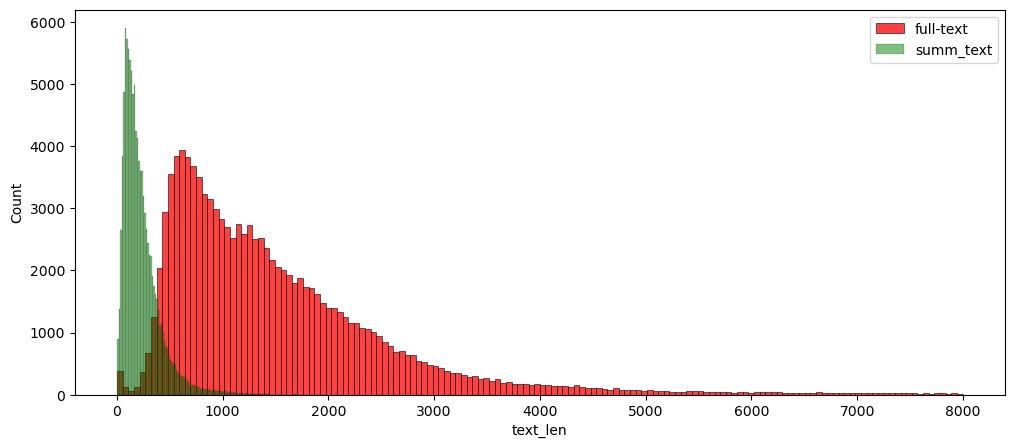

In [16]:
df['text_len'] = df['text_cleaned'].str.len()
df['text_summ_len'] = df['summ_text'].str.len()
fig , ax = plt.subplots(1,1,figsize = (12,5))
sns.histplot(df['text_len']  , bins = 150 , ax = ax , color="red",)
sns.histplot(df['text_summ_len'], bins = 150 , ax = ax , color='green', alpha = 0.5)
ax.legend(['full-text' , 'summ_text'])

In [17]:
#tfidf
vectorizer =TfidfVectorizer(min_df=5 , max_df=0.7 , ngram_range=(1,2) )
vectors = vectorizer.fit_transform(df['summ_text'])

In [ ]:
feature_names = vectorizer.get_feature_names_out()
print(len(feature_names))

105561


In [18]:
cluster_model = KMeans(n_clusters= 10 , init='k-means++' , n_init=1, max_iter=100)
cluster_model.fit(vectors)

KMeans(max_iter=100, n_clusters=10, n_init=1)

In [19]:
order_centroids = cluster_model.cluster_centers_.argsort()[:,::-1]
print(order_centroids.shape)

(10, 105561)


In [20]:
#os.makedirs("../results/tfidf") 
with open("../results/tfidf/tfidfmodel.txt" , "w") as f:
    for i in range(10):
        f.write(f"Cluster {i}\n")
        for ind in order_centroids[i, :10]:
            f.write(f"{feature_names[ind]}\n")
        f.write("\n")

In [21]:
cluster_model.inertia_

106205.00168522651

In [22]:
def get_best_n_topics(vectores , n_ranges = [*range(5 , 10 , 1)]):
    inertia = []
    silhouette_scores = []
    for k in  n_ranges:
        cluster_model = KMeans(n_clusters= k , init='k-means++' , n_init=1 ,random_state=42 , max_iter=150)
        cluster_model.fit(vectores)
        inertia.append(cluster_model.inertia_)
        silhouette_scores.append(silhouette_score(vectores , cluster_model.predict(vectores), random_state=42 , 
                                                  sample_size=10000))
    return n_ranges , inertia , silhouette_scores
    

In [23]:
n_ranges , inertia , silhouette_scores = get_best_n_topics(vectors)

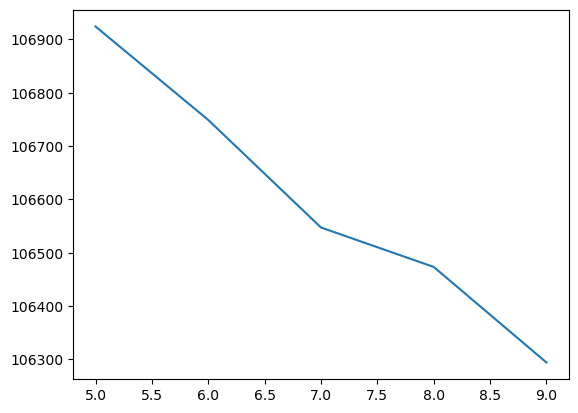

In [24]:
plt.plot(n_ranges , inertia )

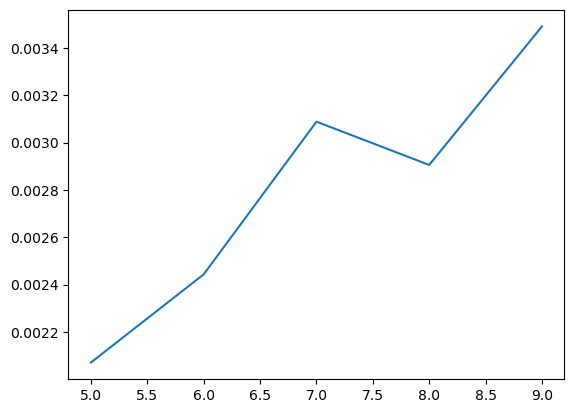

In [25]:
plt.plot(n_ranges ,  silhouette_scores)

In [ ]:
#we can use anthor techniques to get more acuurate results

In [ ]:
#LDA , #NMF

In [27]:
#NMF
text_tfidf = TfidfVectorizer(min_df=2 , max_df=0.7 , ngram_range=(1,3), stop_words=arabic_stopwords )
text_vectors = text_tfidf.fit_transform(df['summ_text'])
print(text_vectors.shape)

c:\Users\oscar\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'أب', 'أخ', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إم', 'ات', 'اتان', 'ارتد', 'ان', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  warnings.warn(


(108143, 698380)


In [31]:
features = text_tfidf.get_feature_names_out()

In [28]:
nmf_text_model = NMF(n_components=10 , random_state=42)
nmf_text_model.fit(text_vectors)

NMF(n_components=10, random_state=42)

In [35]:
def display_topics(model , features , out_file , no_top_words = 7,):
    for topic , word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1]
        f = open(out_file , "w")
        print(f"topic {topic}")
        f.write(f"topic {topic}\n")
        for i in range(no_top_words):
            print(f"- {features[largest[i]]} ({word_vector[largest[i]]*100.0/total:0.2f})")
            f.write(f"- {features[largest[i]]} ({word_vector[largest[i]]*100.0/total:0.2f})\n")
        f.write("\n")
    f.close()
    
        

In [32]:
os.getcwd()

'f:\\NLP-Practices\\Arabic-Text-Theme-Inference-using-Neural-Models-A-Comparative-Study-of-Topic-Modeling-Techniques\\notebooks'

In [33]:
os.mkdir("../results/nmf")

In [36]:
display_topics(nmf_text_model , features , "../results/nmf/nmf_model.txt")

topic 0
- الوطنية (0.21)
- أنها (0.21)
- جديدة (0.20)
- الأمر (0.20)
- بالمغرب (0.18)
- خلال (0.18)
- الصحراء (0.17)
topic 1
- زوروا (1.66)
- والرياضي زوروا (1.63)
- والرياضي (1.63)
- أخبار (1.62)
- الرياضة والرياضي (1.62)
- الرياضة والرياضي زوروا (1.62)
- الرياضة (1.61)
topic 2
- مليون (2.78)
- مليار (1.04)
- المائة (0.60)
- مليون مليون (0.59)
- بنسبة (0.40)
- التقرير (0.21)
- المالية (0.20)
topic 3
- بنكيران (4.31)
- الحكومة (0.62)
- المصباح (0.32)
- متابعة (0.29)
- بنكيران بنكيران (0.28)
- الاستقلال (0.26)
- البيجيدي (0.22)
topic 4
- الشرطة (0.75)
- عناصر (0.47)
- القضائية (0.42)
- حالة (0.35)
- الشرطة القضائية (0.31)
- للشرطة (0.30)
- عناصر الشرطة (0.29)
topic 5
- ملال (3.56)
- بني (2.89)
- بني ملال (2.82)
- رجاء بني (1.42)
- رجاء (1.40)
- رجاء بني ملال (1.37)
- فالق (0.44)
topic 6
- البيضاء (1.55)
- الخامس (1.48)
- محمد (1.47)
- محمد الخامس (1.35)
- ملعب (0.61)
- بالدار (0.46)
- بالدار البيضاء (0.45)
topic 7
- الفريق (0.59)
- النادي (0.55)
- البطولة (0.48)
- أولمبيك (0.47)
- خريبك

In [ ]:
#we see some toics are rsame we can reduce this more 

In [39]:
nmf_text_model = NMF(n_components=7 , random_state=42)
nmf_text_model.fit(text_vectors)

NMF(n_components=7, random_state=42)

In [40]:
display_topics(nmf_text_model , features , "../results/nmf/nmf_model.txt")

topic 0
- الإفريقية (0.39)
- البطولة (0.34)
- الفريق (0.32)
- الوطنية (0.28)
- كأس (0.28)
- النادي (0.25)
- المباريات (0.23)
topic 1
- زوروا (1.59)
- والرياضي زوروا (1.56)
- والرياضي (1.55)
- أخبار (1.55)
- الرياضة والرياضي (1.55)
- الرياضة والرياضي زوروا (1.54)
- الرياضة (1.54)
topic 2
- مليون (1.66)
- مليار (0.73)
- المائة (0.45)
- مليون مليون (0.34)
- بنسبة (0.29)
- خلال (0.24)
- التقرير (0.19)
topic 3
- بنكيران (1.44)
- والمعاصرة (0.82)
- الأصالة (0.73)
- الأصالة والمعاصرة (0.71)
- الحكومة (0.35)
- أحزاب (0.19)
- الاستقلال (0.18)
topic 4
- الشرطة (0.55)
- عناصر (0.34)
- القضائية (0.31)
- حالة (0.29)
- الشرطة القضائية (0.23)
- للشرطة (0.22)
- النيابة (0.21)
topic 5
- ملال (3.24)
- بني (2.63)
- بني ملال (2.57)
- رجاء بني (1.29)
- رجاء (1.28)
- رجاء بني ملال (1.25)
- الرتبة (0.46)
topic 6
- البيضاء (1.28)
- محمد (1.20)
- الخامس (1.14)
- محمد الخامس (1.04)
- ملعب (0.47)
- بالدار (0.36)
- بالدار البيضاء (0.36)


In [43]:
def wordcloud_topics(model , features , save_dir , no_top_words = 50 ):
    font = "../../topic-modeling/Noto_Sans_Arabic/NotoSansArabic-VariableFont_wdth,wght.ttf"
    for topic , words in enumerate(model.components_):
        size ={}
        
        largest = words.argsort()[::-1]
        for i in range(0 , no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud( font_path= font  , background_color='white' , max_words=100 , width=950 , height=500 ,   colormap='Paired')
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12, 12))
        plt.imshow(wc , interpolation='bilinear')
        plt.axis("off")
        plt.savefig(os.path.join(save_dir , f"topic{topic}.png"))

c:\Users\oscar\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\oscar\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\oscar\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\U

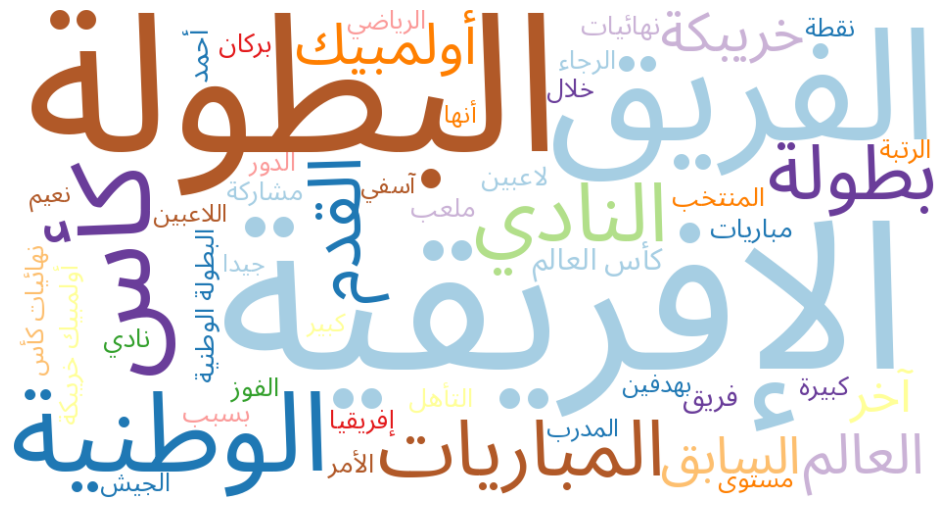

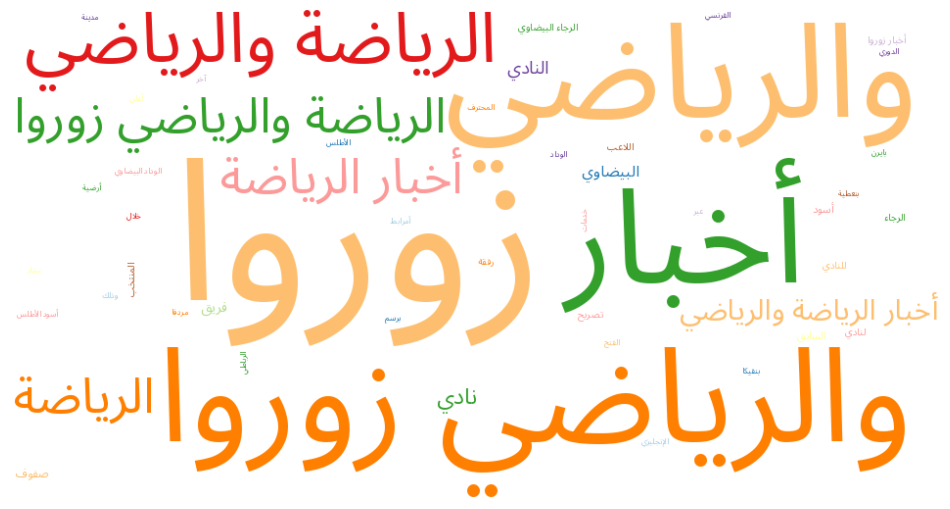

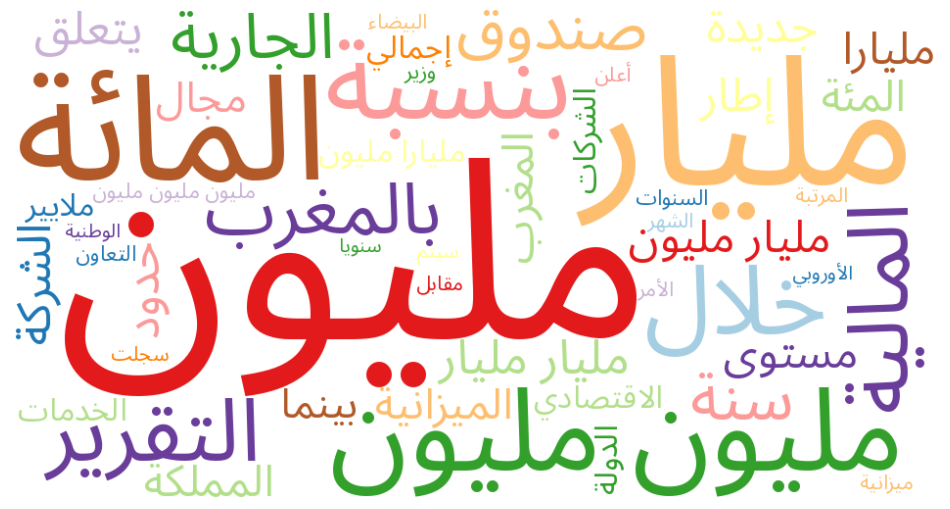

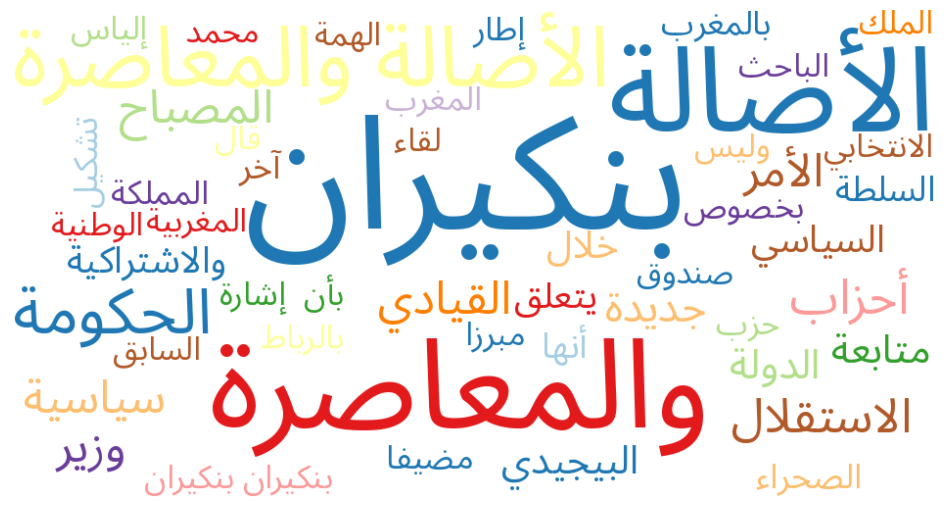

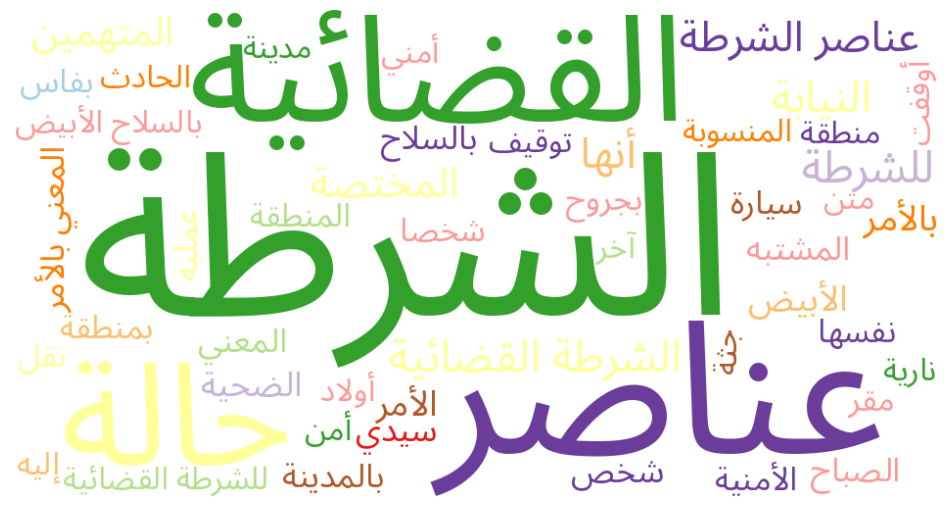

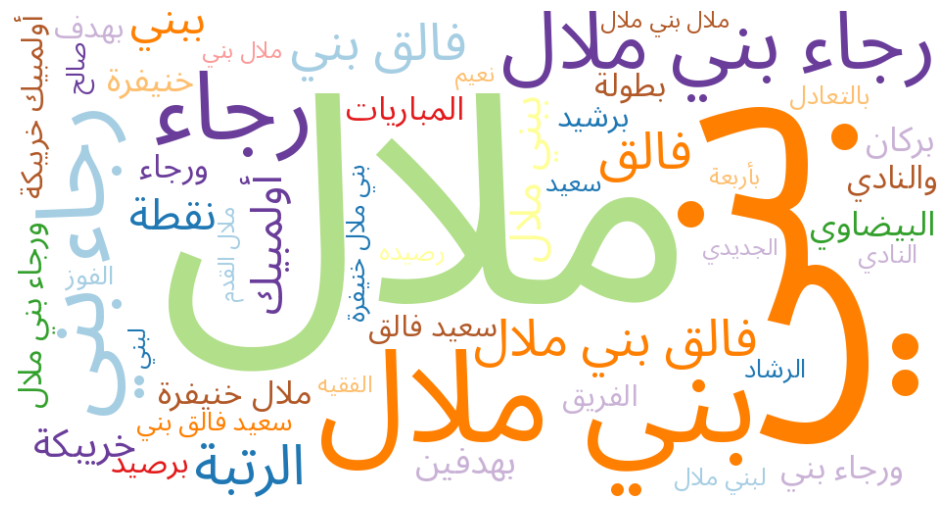

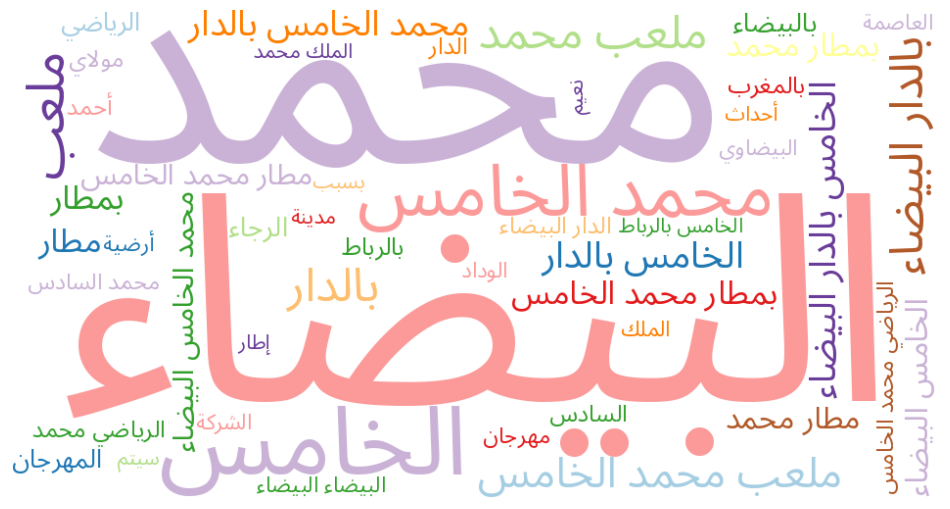

In [44]:
wordcloud_topics(nmf_text_model , features , "../results/nmf")

In [45]:
Truncated_svd_model = TruncatedSVD(n_components=7 , random_state=42)
Truncated_svd_model.fit(vectors)

TruncatedSVD(n_components=7, random_state=42)

In [46]:
os.mkdir("../results/truncated_svd")

In [47]:
display_topics(Truncated_svd_model , features , out_file="../results/truncated_svd/truncated_svd_model.txt")

topic 0
- الاغتصاب إضافة مساطر (0.27)
- أشهر الصحراء (0.24)
- أرضية دستورية (0.24)
- إخبار المعني (0.24)
- الإيديولوجيا الطائفي (0.22)
- أنني يكون (0.20)
- أشار أوبرمان عازمان (0.18)
topic 1
- إجمالي الرسملة بالأسواق (-0.97)
- أشار أوبرمان عازمان (-0.88)
- أنني يكون (-0.85)
- اقترحتم (-0.84)
- آخر رئيسا للحكومة (-0.78)
- البلاد مبرزا (-0.76)
- البلاد مشيرا (-0.76)
topic 2
- الاغتصاب إضافة مساطر (-7.08)
- الاعتبارية ناخبا وطنيا (-3.60)
- إنتاج الدقيق (-2.46)
- أنها لائحة (-2.15)
- الاقتصادي التقرير يرى (-1.52)
- البوز طويلا (-1.45)
- إمكانيات البلد الإفريقية (-1.42)
topic 3
- إنتاج الدقيق (19.19)
- البوز طويلا (14.34)
- أخيرا بالتالي مسؤوليته (12.81)
- أخيرا بالجزائر (12.51)
- أغلبها إعدادية (4.17)
- آخر تتم مجلس (2.70)
- أسرته بدوار الحرارشة (2.53)
topic 4
- اقترحتم (9.78)
- آخر رئيسا للحكومة (9.61)
- البلاد مشيرا (9.43)
- البلاد مبرزا (9.43)
- أكادير ويدخل (9.35)
- أكادير ووداد النواصر (9.31)
- آخر ربع (9.17)
topic 5
- الاشتراك بالنسبة مساهمات (-17.39)
- إنجاز بنيات (-14.10)
- إنجاز ج

c:\Users\oscar\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\oscar\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\oscar\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\U

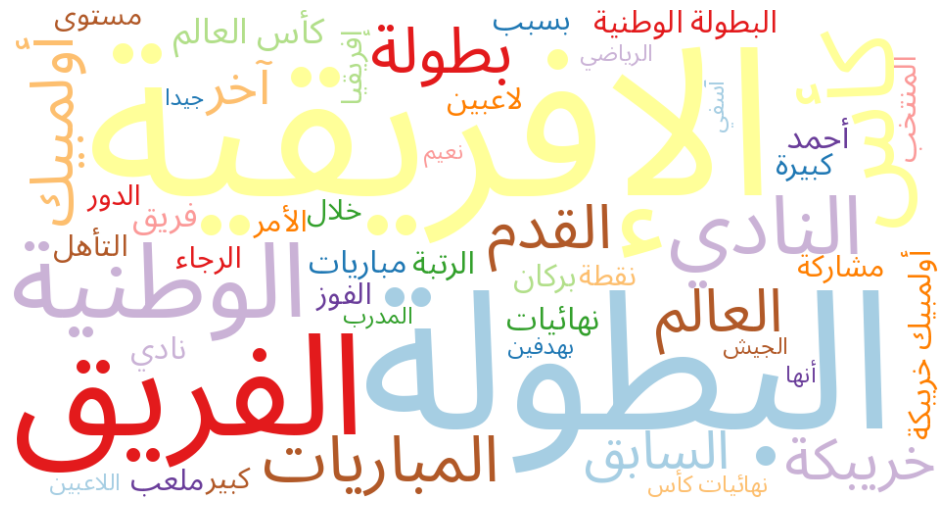

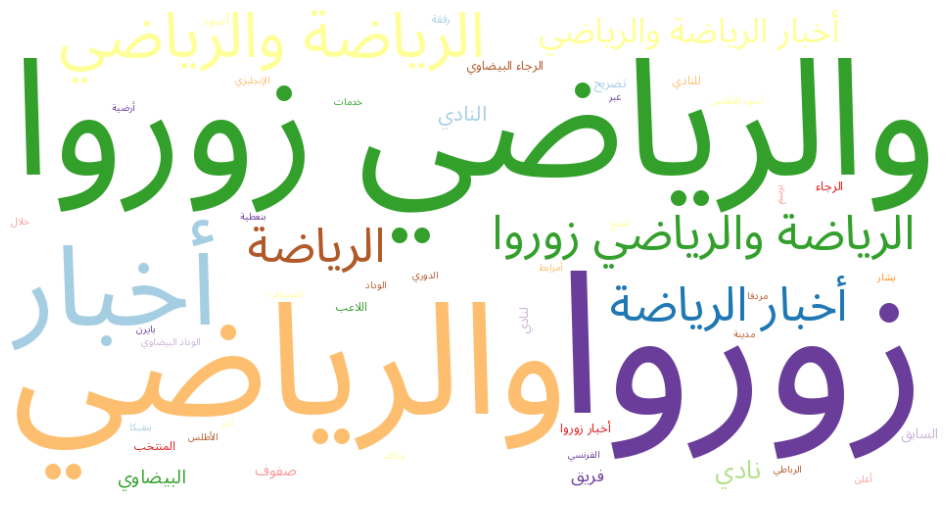

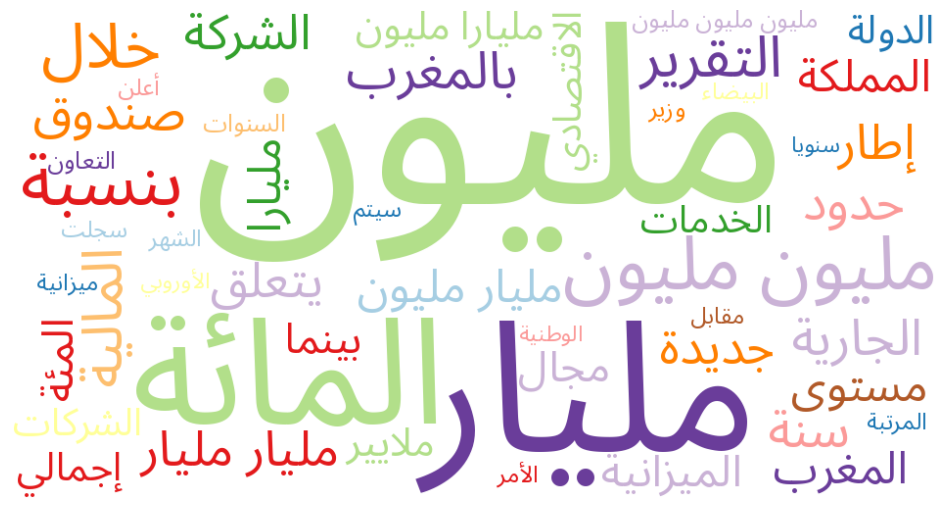

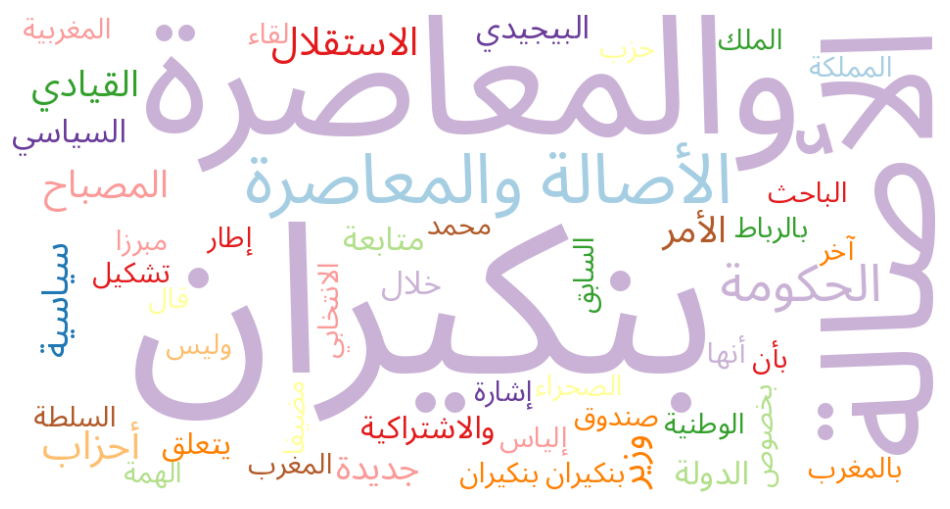

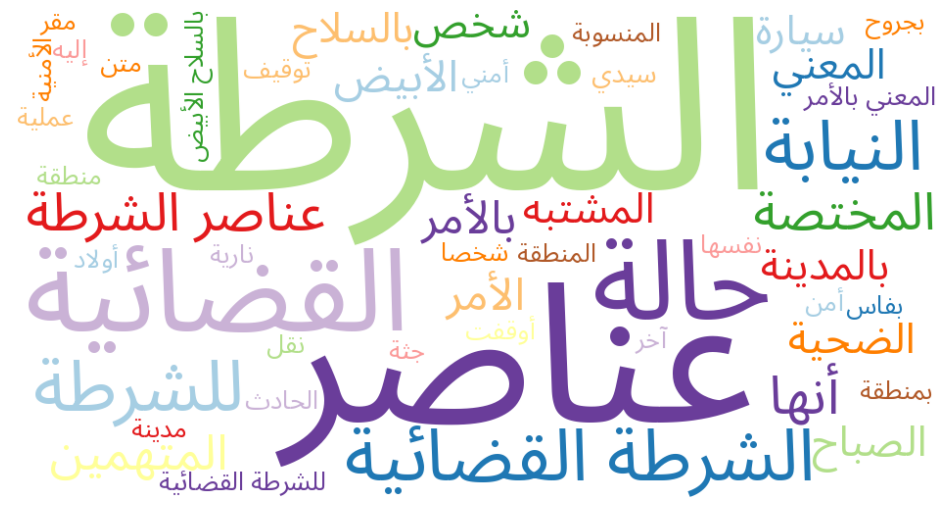

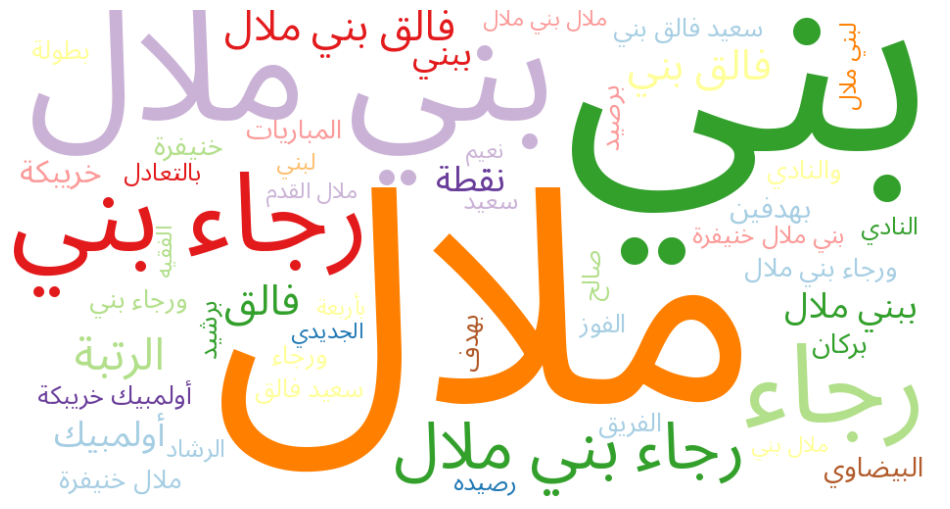

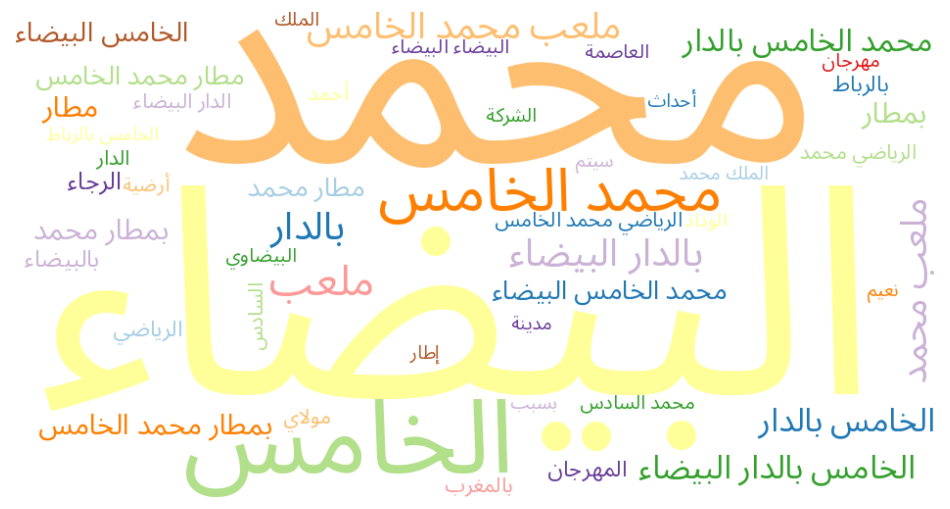

In [48]:
wordcloud_topics(nmf_text_model , features , "../results/truncated_svd")

In [49]:
lad_model = LatentDirichletAllocation(n_components=6 , random_state=42)
lad_model.fit(vectors)

LatentDirichletAllocation(n_components=6, random_state=42)

In [50]:
os.mkdir("../results/lda")


In [51]:
display_topics(Truncated_svd_model , features , out_file="../results/lda/lda_model.txt")

topic 0
- الاغتصاب إضافة مساطر (0.27)
- أشهر الصحراء (0.24)
- أرضية دستورية (0.24)
- إخبار المعني (0.24)
- الإيديولوجيا الطائفي (0.22)
- أنني يكون (0.20)
- أشار أوبرمان عازمان (0.18)
topic 1
- إجمالي الرسملة بالأسواق (-0.97)
- أشار أوبرمان عازمان (-0.88)
- أنني يكون (-0.85)
- اقترحتم (-0.84)
- آخر رئيسا للحكومة (-0.78)
- البلاد مبرزا (-0.76)
- البلاد مشيرا (-0.76)
topic 2
- الاغتصاب إضافة مساطر (-7.08)
- الاعتبارية ناخبا وطنيا (-3.60)
- إنتاج الدقيق (-2.46)
- أنها لائحة (-2.15)
- الاقتصادي التقرير يرى (-1.52)
- البوز طويلا (-1.45)
- إمكانيات البلد الإفريقية (-1.42)
topic 3
- إنتاج الدقيق (19.19)
- البوز طويلا (14.34)
- أخيرا بالتالي مسؤوليته (12.81)
- أخيرا بالجزائر (12.51)
- أغلبها إعدادية (4.17)
- آخر تتم مجلس (2.70)
- أسرته بدوار الحرارشة (2.53)
topic 4
- اقترحتم (9.78)
- آخر رئيسا للحكومة (9.61)
- البلاد مشيرا (9.43)
- البلاد مبرزا (9.43)
- أكادير ويدخل (9.35)
- أكادير ووداد النواصر (9.31)
- آخر ربع (9.17)
topic 5
- الاشتراك بالنسبة مساهمات (-17.39)
- إنجاز بنيات (-14.10)
- إنجاز ج

c:\Users\oscar\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\oscar\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\oscar\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\U

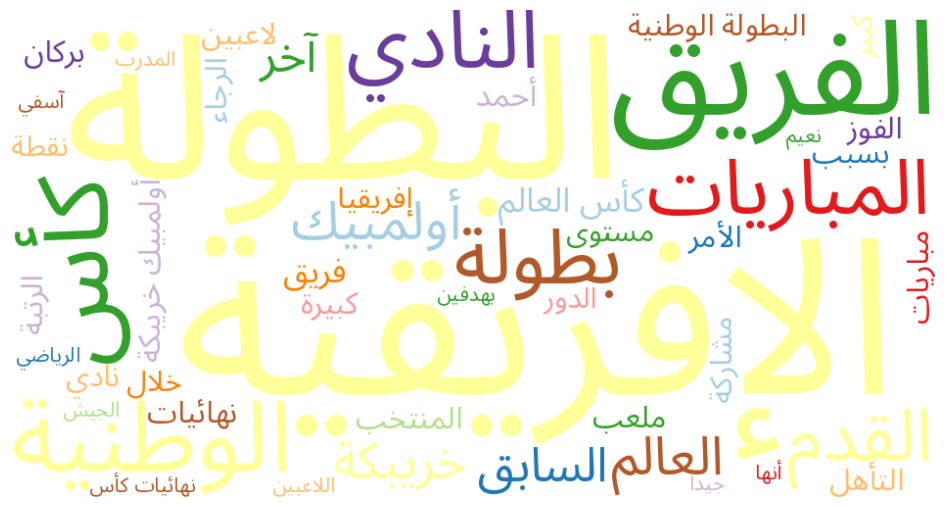

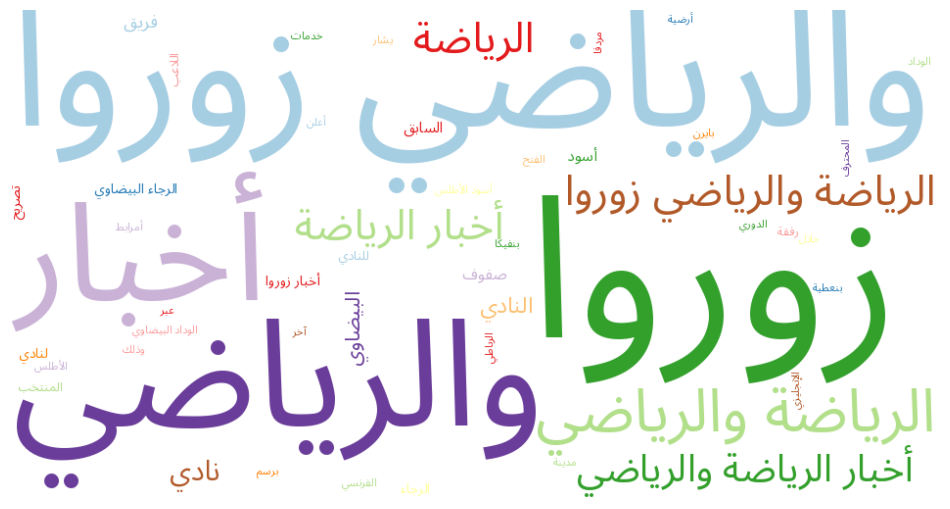

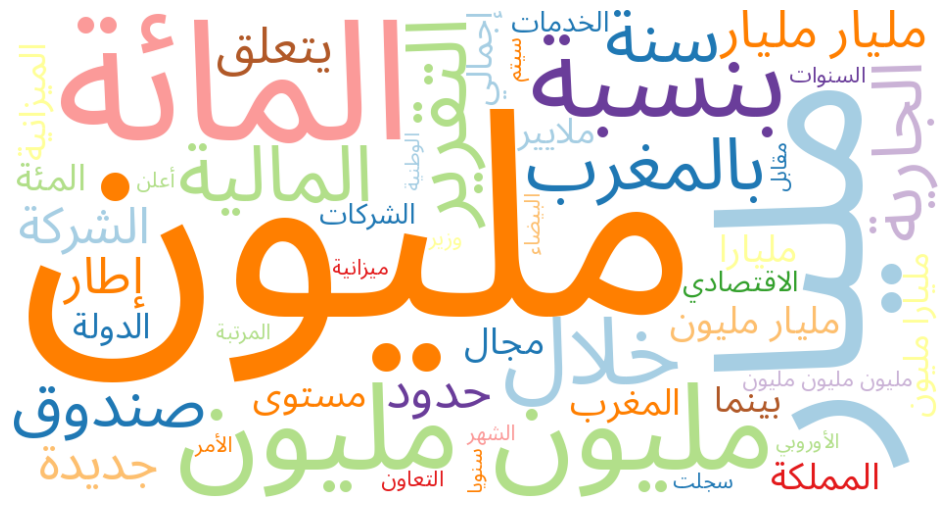

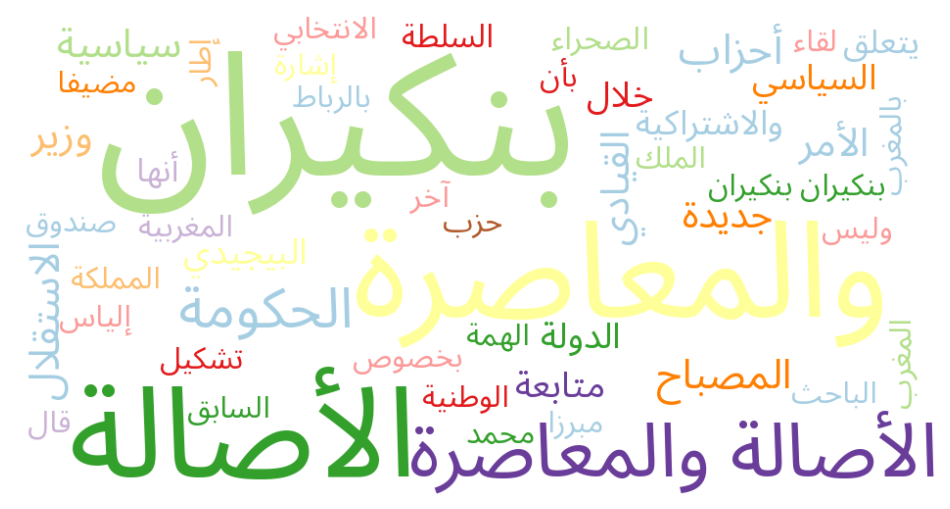

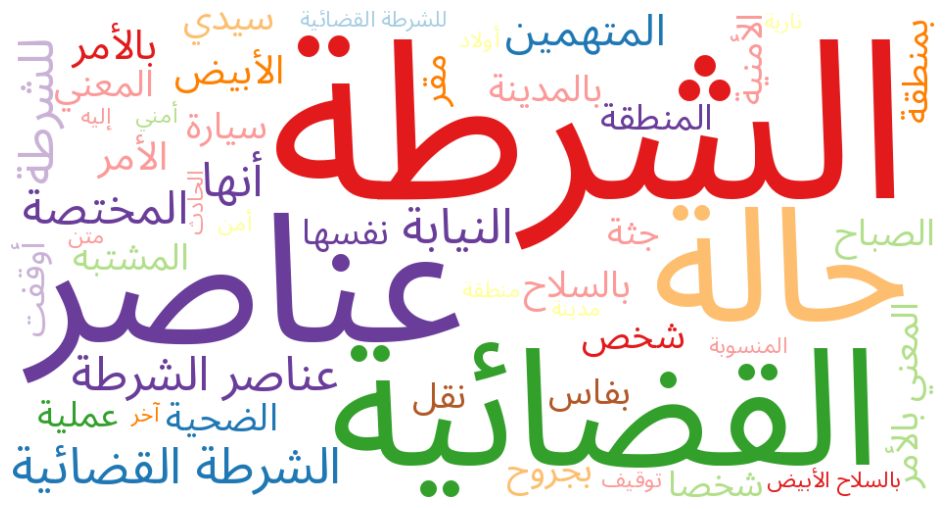

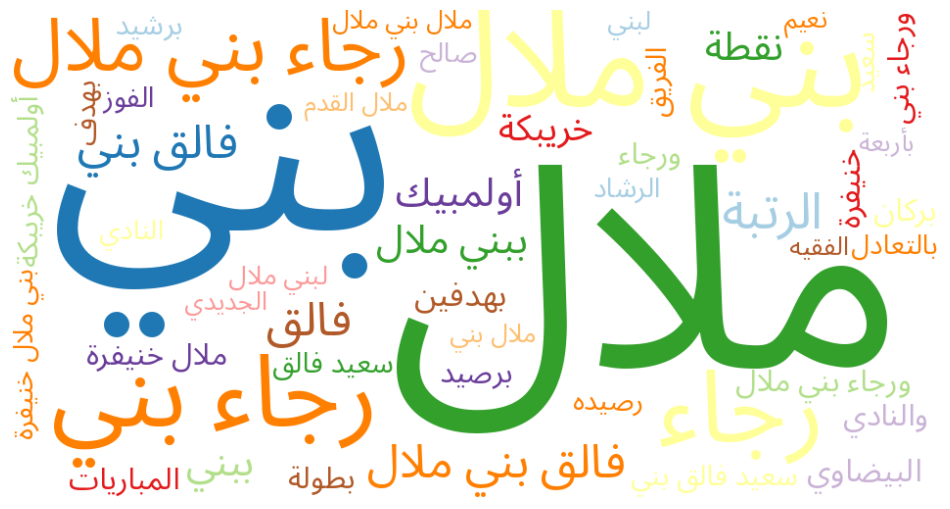

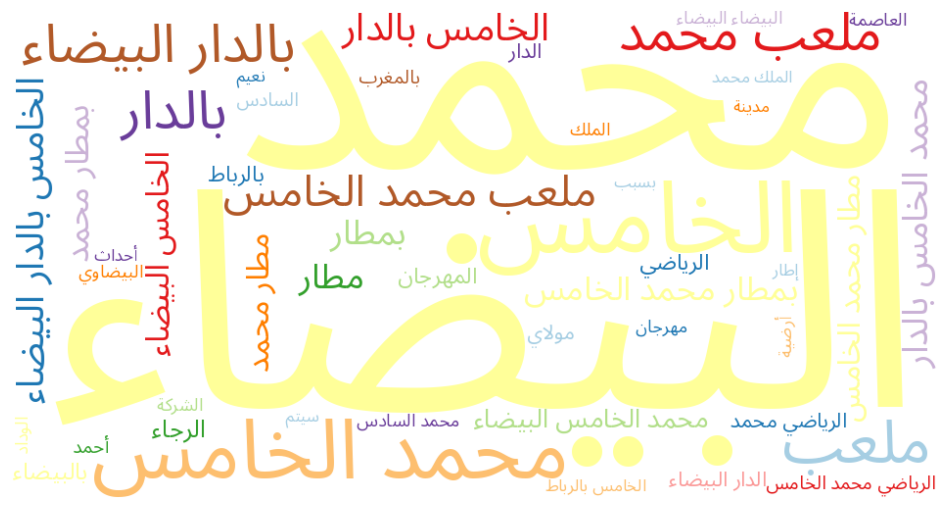

In [52]:
wordcloud_topics(nmf_text_model , features , "../results/lda")